In [1]:
import h5py
import cv2
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import os, sys, numpy as np
import torch
from torch.utils.data import sampler, DataLoader
from skimage.transform import resize

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from sononet.utils.util import json_file_to_pyobj
from sononet.models import get_model
from sononet.dataio.loader import get_dataset, get_dataset_path
from sononet.dataio.transformation import get_dataset_transformation
from sononet.utils.visualiser import Visualiser
from sononet.utils.error_logger import ErrorLogger
from sononet.models.networks_other import adjust_learning_rate

In [2]:
json_filename = 'configs/config_sononet_8_andi.json'
json_opts = json_file_to_pyobj(json_filename)
train_opts = json_opts.training

In [3]:
us_data = h5py.File('data/image_inp_224x288.hdf5')

In [4]:
cardiac_classes = [1, 2, 22, 29]

In [5]:
us_data['label_names'].value[cardiac_classes]

array([b'3VV', b'4CH', b'LVOT', b'RVOT'], dtype='|S16')

In [6]:
card_train_id = np.array([i in cardiac_classes for i in us_data['plane_labels_train'].value])
card_test_id = np.array([i in cardiac_classes for i in us_data['plane_labels_test'].value])

In [7]:
card_images_train = torch.tensor(us_data['images_train'][card_train_id,:,:,:])
card_labels_train = torch.tensor([{1: 0, 2:1, 22:2, 29:3}[lab] for lab in us_data['plane_labels_train'][card_train_id]])

card_images_test = torch.tensor(us_data['images_test'][card_test_id,:,:,:])
card_labels_test = torch.tensor([{1: 0, 2:1, 22:2, 29:3}[lab] for lab in us_data['plane_labels_test'][card_test_id]])

In [8]:
arch_type = train_opts.arch_type
ds_transform = get_dataset_transformation(arch_type, opts=json_opts.augmentation)



############# Augmentation Parameters #############
{'division_factor': (16, 16, 1),
 'inten_val': (1.0, 1.0),
 'name': 'us',
 'patch_size': [208, 272],
 'random_flip_prob': 0.5,
 'rotate_val': 15.0,
 'scale_size': (192, 192, 1),
 'scale_val': (0.7, 1.3),
 'shift_val': (0.1, 0.1)}
###################################################




In [9]:
class SimpleUSDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, transform=None):
        super().__init__(*data)

        self.images = data[0]
        self.labels = data[1]

        self.label_names, lab_count = np.unique(self.labels, return_counts=True)
        self.n_class = len(self.label_names)
        self.weight = (1. / lab_count)[self.labels]
        
        # data augmentation
        self.transform = transform

    def __getitem__(self, index):

        indata  = self.images[index][0]
        target = self.labels[index]

        if self.transform:
            indata = self.transform(indata.numpy())
        return indata, int(target)

    def __len__(self):
        return len(self.images)

In [10]:
class AlteredUSDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, transform=None):
        super().__init__(*data)

        self.images = data[0]
        self.labels = data[1]
        self.embedding = data[2]

        self.label_names, lab_count = np.unique(self.labels, return_counts=True)
        self.n_class = len(self.label_names)
        self.weight = (1. / lab_count)[self.labels]
        
        # data augmentation
        self.transform = transform

    def __getitem__(self, index):

        indata  = self.images[index][0]
        target = self.labels[index]
        emb = self.embedding[index]

        if self.transform:
            indata = self.transform(indata.numpy())
        return indata, int(target), emb

    def __len__(self):
        return len(self.images)

In [11]:
train_dataset = SimpleUSDataset(
    (card_images_train, card_labels_train),
    transform=ds_transform['train'])
train_dataset_for_acc = SimpleUSDataset(
    (card_images_train, card_labels_train),
    transform=ds_transform['valid'])
test_dataset = SimpleUSDataset(
    (card_images_test, card_labels_test),
        transform=ds_transform['valid'])

In [12]:
batch_size = train_opts.batchSize
train_sampler = sampler.WeightedRandomSampler(train_dataset.weight, batch_size)

In [13]:
train_loader = DataLoader(train_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=True)
#    sampler=train_sampler)

train_loader_for_acc = DataLoader(train_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=False)

test_loader  = DataLoader(test_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=False)

In [14]:
def print_accuracy(model, fold):
    model.net.eval()
    if fold == 'train':
        loader = train_loader_for_acc
    elif fold == 'test':
        loader = test_loader
    labels = []
    preds = []
    for (img, lab) in loader:
        labels.append(lab.cpu())
        model.set_input(img)
        model.forward(split='test')
        preds.append(model.logits.cpu().argmax(dim=1))
    labels = torch.cat(labels)
    preds = torch.cat(preds)
    acc = (labels==preds).sum().float() / len(labels)
    print('Accuracy {fold}: {acc}'.format(
        fold=fold, acc=acc
    ))
    return acc

In [15]:
model = get_model(json_opts.model)


Initialising model sononet2
Network is initialized
sononet(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(

In [16]:
model.set_labels([0,1,2,3])
model.set_scheduler(train_opts)
model.load_network(model.net, 'S', 50)
model.update_state(0)

opt.lr_policy = [step_warmstart]
Scheduler is added for optimiser SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.1
    lr: 0.010000000000000002
    momentum: 0.9
    nesterov: True
    weight_decay: 1e-06
)
Loading the model S - epoch 50


In [17]:
for epoch in tqdm(range(1, 51)):
    for (images, labels) in train_loader:
        # Make a training update
        model.net.train()
        model.set_input(images, labels)
        model.optimize_parameters()

    if epoch % 5 == 0:
        model.save(epoch)
        print_accuracy(model, 'train')
        print_accuracy(model, 'test')

    if epoch == 25:
        model.update_learning_rate()

        #model.update_learning_rate(metric=valid_err, epoch=epoch)

8%|▊         | 4/50 [00:33<06:26,  8.41s/it]Saving the model S at the end of epoch 5
Accuracy train: 0.469453364610672
 18%|█▊        | 9/50 [01:27<06:30,  9.53s/it]Saving the model S at the end of epoch 10
Accuracy train: 0.5857449173927307
 28%|██▊       | 14/50 [02:23<06:01, 10.04s/it]Saving the model S at the end of epoch 15
Accuracy train: 0.6034297943115234
 38%|███▊      | 19/50 [03:21<05:20, 10.33s/it]Saving the model S at the end of epoch 20
Accuracy train: 0.6704180240631104
 48%|████▊     | 24/50 [04:20<04:34, 10.55s/it]Saving the model S at the end of epoch 25
Accuracy train: 0.6864951848983765
 50%|█████     | 25/50 [04:41<05:44, 13.79s/it]Accuracy test: 0.7625330090522766
current learning rate = 0.0100000
 58%|█████▊    | 29/50 [05:21<03:48, 10.89s/it]Saving the model S at the end of epoch 30
Accuracy train: 0.6012861728668213
 68%|██████▊   | 34/50 [06:23<02:55, 10.97s/it]Saving the model S at the end of epoch 35
Accuracy train: 0.6307609677314758
 78%|███████▊  | 39/50 

In [17]:
print_accuracy(model, 'train')

Accuracy train: 0.7513397932052612


tensor(0.7513)

In [18]:
def get_logits(model, fold, softmax=True):
    model.net.eval()
    with torch.no_grad():
        if fold == 'train':
            loader = train_loader_for_acc
        elif fold == 'test':
            loader = test_loader
        labels = []
        logits = []
        for (img, lab) in loader:
            labels.append(lab.cpu())
            model.set_input(img)
            model.forward(split='test')
            if softmax:
                logits.append(model.logits.cpu())
            else:
                logits.append(model.prediction.cpu())
        labels = torch.cat(labels)
        logits = torch.cat(logits)
        return logits, labels

In [19]:
logits_train_before, labels_train = get_logits(model, 'train', softmax=False)

In [20]:
from ptsne.ptsne import ParametricTSNE

In [21]:
ptsne = ParametricTSNE(4, 2, 50, use_cuda=True, hidden_layer_dims=[200,50], alpha='learn')

In [22]:
ptsne.fit(logits_train_before, pretrain=True, verbose=True)

Calculating PCA
2020-03-12 00:35:40.958749: Beginning pretraining for 5 epochs
2020-03-12 00:35:41.241300: Loss after epoch 0: 7.335207760334015
2020-03-12 00:35:41.274300: Loss after epoch 1: 2.161160111427307
2020-03-12 00:35:41.308300: Loss after epoch 2: 1.1218474507331848
2020-03-12 00:35:41.346300: Loss after epoch 3: 0.6773773357272148
2020-03-12 00:35:41.440385: Loss after epoch 4: 0.6376223564147949
2020-03-12 00:35:41.440385: Finished pretraining
Indexing
2020-03-12 00:35:55.567928: Beginning training for 10 epochs
2020-03-12 00:35:55.682927: Loss after epoch 1: 6.50575824230838
2020-03-12 00:35:55.784931: Loss after epoch 2: 3.9593972524073364
2020-03-12 00:35:55.902932: Loss after epoch 3: 3.54203044399531
2020-03-12 00:35:56.022930: Loss after epoch 4: 3.5618892946586502
2020-03-12 00:35:56.129932: Loss after epoch 5: 3.5144517529678874
2020-03-12 00:35:56.253932: Loss after epoch 6: 3.478972371488199
2020-03-12 00:35:56.378928: Loss after epoch 7: 3.431361267272817
2020-0

In [23]:
projected = ptsne(logits_train_before.cuda()).cpu().detach()

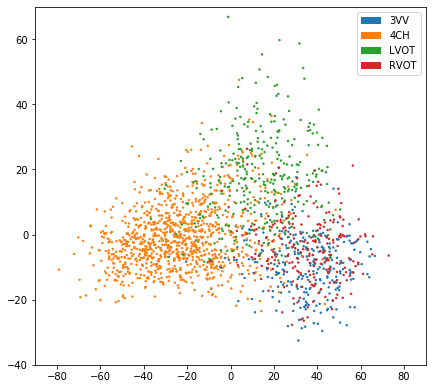

In [105]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in card_labels_train]
ax.scatter(projected[:,0], projected[:,1], c=colors, s=2)
ax.set_aspect(1.5)
ax.set_xlim([-90,90])
ax.set_ylim([-40,70])
recs = []
for i in range(0,4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in us_data['label_names'].value[cardiac_classes]],loc=1)

In [118]:
shifted_train = torch.cat((
    (1./2. * projected[(card_labels_train == 0)] + 1./2. * projected[(card_labels_train == 0)].mean(axis=0)) + torch.tensor([3.,-5.]),
    (3./4. * projected[(card_labels_train == 1)] + 1./4. * projected[(card_labels_train == 1)].mean(axis=0)) + torch.tensor([-10.,-8.]),
    (1./2. * projected[(card_labels_train == 2)] + 1./2. * projected[(card_labels_train == 2)].mean(axis=0)) + torch.tensor([5.,15.]),
    (1./2. * projected[(card_labels_train == 3)] + 1./2. * projected[(card_labels_train == 3)].mean(axis=0)) + torch.tensor([-8.,+4.]) 
))

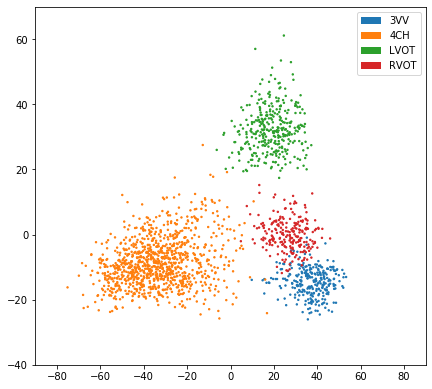

In [119]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in card_labels_train]
ax.scatter(shifted_train[:,0], shifted_train[:,1], c=colors, s=2)
ax.set_aspect(1.5)
ax.set_xlim([-90,90])
ax.set_ylim([-40,70])
recs = []
for i in range(0,4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in us_data['label_names'].value[cardiac_classes]],loc=1)

In [72]:
shifted_dataset = AlteredUSDataset((card_images_train, card_labels_train, shifted_train), transform=ds_transform['valid'])
shifted_loader = DataLoader(shifted_dataset, batch_size=batch_size, shuffle=True)
shifted_dataset_no_tf = AlteredUSDataset((card_images_train, card_labels_train, shifted_train), transform=ds_transform['valid'])
shifted_loader_noshuffle = DataLoader(shifted_dataset_no_tf, batch_size=batch_size, shuffle=False)

In [77]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)
torch.backends.cudnn.deterministic=True

model.load_network(model.net, 'S', 50)
model.update_state(0)
model.optimizer.param_groups[0]['lr'] = 0.002

for epoch in tqdm(range(1, 25)):
    for idx, (images, labels, emb) in enumerate(shifted_loader):
        # Make a training update
        model.net.train()
        model.set_input(images, labels)

        model.optimize_parameters_altered(ptsne, emb.cuda(), 0.1, print_loss=(idx % 3 == 0))

    model.save_network(model.net, 'emb_010_from_50', epoch, model.gpu_ids)
    
    # if epoch == 10:
    #      model.optimizer.param_groups[0]['lr'] = 0.0001

    # if epoch == 25:
    #     model.update_learning_rate()

        #model.update_learning_rate(metric=valid_err, epoch=epoch)





  0%|          | 0/15 [00:00<?, ?it/s]Loading the model S - epoch 50
Classification loss: 0.43911775946617126
Embedding loss: 4.796328067779541
Classification loss: 0.43499523401260376
Embedding loss: 3.9808504581451416
Classification loss: 0.5276447534561157
Embedding loss: 4.748013973236084
Classification loss: 0.6175557374954224
Embedding loss: 5.521317958831787
Classification loss: 0.44015389680862427
Embedding loss: 4.1817498207092285
Classification loss: 0.5147514939308167
Embedding loss: 4.716030120849609
Classification loss: 0.5951828956604004
Embedding loss: 4.2386932373046875
Classification loss: 0.43750110268592834
Embedding loss: 3.448147773742676
Classification loss: 0.39909231662750244
Embedding loss: 2.841304302215576
Classification loss: 0.4379896819591522
Embedding loss: 3.0725083351135254
Classification loss: 0.4270505905151367
Embedding loss: 3.5221638679504395
Classification loss: 0.45323655009269714
Embedding loss: 2.9033265113830566




  7%|▋         | 1/15 [

In [78]:
logits_emb = {'train':[], 'test':[]}
for epoch in range(1, 16):
    model.load_network(model.net, 'emb_020_from_50', epoch)
    logits_emb['train'].append(get_logits(model, 'train', softmax=False)[0])
    logits_emb['test'].append(get_logits(model, 'test', softmax=False)[0])
logits_emb['train'] = torch.stack(logits_emb['train'])
logits_emb['test'] = torch.stack(logits_emb['test'])
torch.save(logits_emb, 'checkpoints/ifind1_sononet_8_andi/logits_emb_010_from_50.pt')

Loading the model emb_020_from_50 - epoch 1
Loading the model emb_020_from_50 - epoch 2
Loading the model emb_020_from_50 - epoch 3
Loading the model emb_020_from_50 - epoch 4
Loading the model emb_020_from_50 - epoch 5
Loading the model emb_020_from_50 - epoch 6
Loading the model emb_020_from_50 - epoch 7
Loading the model emb_020_from_50 - epoch 8
Loading the model emb_020_from_50 - epoch 9
Loading the model emb_020_from_50 - epoch 10
Loading the model emb_020_from_50 - epoch 11
Loading the model emb_020_from_50 - epoch 12
Loading the model emb_020_from_50 - epoch 13
Loading the model emb_020_from_50 - epoch 14
Loading the model emb_020_from_50 - epoch 15


In [74]:
logits_class = {'train':[], 'test':[]}
for epoch in range(1, 16):
    model.load_network(model.net, 'class_only_from_50', epoch)
    logits_class['train'].append(get_logits(model, 'train', softmax=False)[0])
    logits_class['test'].append(get_logits(model, 'test', softmax=False)[0])
logits_class['train'] = torch.stack(logits_class['train'])
logits_class['test'] = torch.stack(logits_class['test'])
torch.save(logits_emb, 'checkpoints/ifind1_sononet_8_andi/logits_class_only_from_50.pt')

Loading the model class_only_from_50 - epoch 1
Loading the model class_only_from_50 - epoch 2
Loading the model class_only_from_50 - epoch 3
Loading the model class_only_from_50 - epoch 4
Loading the model class_only_from_50 - epoch 5
Loading the model class_only_from_50 - epoch 6
Loading the model class_only_from_50 - epoch 7
Loading the model class_only_from_50 - epoch 8
Loading the model class_only_from_50 - epoch 9
Loading the model class_only_from_50 - epoch 10
Loading the model class_only_from_50 - epoch 11
Loading the model class_only_from_50 - epoch 12
Loading the model class_only_from_50 - epoch 13
Loading the model class_only_from_50 - epoch 14
Loading the model class_only_from_50 - epoch 15


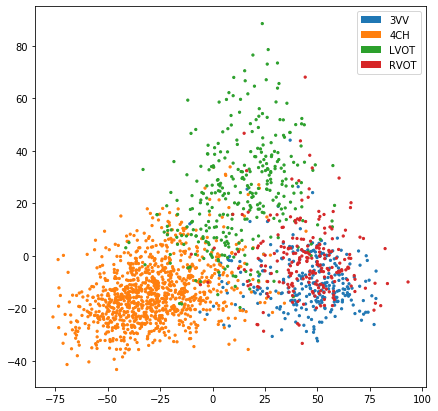

In [75]:
projected_altered = ptsne(logits_class['train'][-1].cuda()).cpu().detach()
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in card_labels_train]
ax.scatter(projected_altered[:,0], projected_altered[:,1], c=colors, s=5)
#ax.set_aspect(1)
recs = []
for i in range(0,4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in us_data['label_names'].value[cardiac_classes]],loc=1)

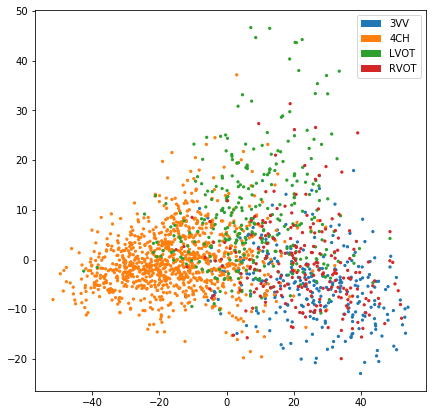

In [79]:
projected_altered = ptsne(logits_emb['train'][-1].cuda()).cpu().detach()
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in card_labels_train]
ax.scatter(projected_altered[:,0], projected_altered[:,1], c=colors, s=5)
#ax.set_aspect(1)
recs = []
for i in range(0,4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in us_data['label_names'].value[cardiac_classes]],loc=1)

In [41]:
def confmat(data):
    cf = torch.zeros(4,4, dtype=torch.int)
    for logits, label, in zip(*data):
        cf[label, logits.softmax(dim=0).argmax()] += 1
    return cf

In [42]:
def accuracy(data):
    cf = confmat(data)
    diag = cf.diagonal().sum()
    total = cf.sum()
    return diag.float() / total

In [43]:
def precision(data, c):
    cf = confmat(data)
    return cf[c,c].float() / cf[:,c].sum().float()

In [44]:
def recall(data, c):
    cf = confmat(data)
    return cf[c,c].float() / cf[c,:].sum().float()

In [45]:
def f_score(data, c):
    cf = confmat(data)
    prec = cf[c,c].float() / cf[:,c].sum().float()
    rec = cf[c,c].float() / cf[c,:].sum().float()
    return torch.sqrt(prec * rec)

In [80]:
accs_train_class = [accuracy((log, card_labels_train)) for log in logits_class['train']]
accs_test_class = [accuracy((log, card_labels_test)) for log in logits_class['test']]

In [81]:
accs_train_emb = [accuracy((log, card_labels_train)) for log in logits_emb['train']]
accs_test_emb = [accuracy((log, card_labels_test)) for log in logits_emb['test']]

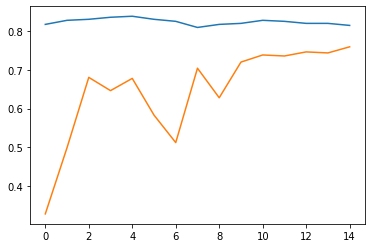

In [94]:
plt.plot(accs_test_class)
plt.plot(accs_test_emb)

In [95]:
f_score_0_test_class = [f_score((log, card_labels_test), 0) for log in logits_class['train']]
f_score_1_test_class = [f_score((log, card_labels_test), 1) for log in logits_class['train']]
f_score_2_test_class = [f_score((log, card_labels_test), 2) for log in logits_class['train']]
f_score_3_test_class = [f_score((log, card_labels_test), 3) for log in logits_class['train']]

In [96]:
f_score_0_test_emb = [f_score((log, card_labels_test), 0) for log in logits_emb['train']]
f_score_1_test_emb = [f_score((log, card_labels_test), 1) for log in logits_emb['train']]
f_score_2_test_emb = [f_score((log, card_labels_test), 2) for log in logits_emb['train']]
f_score_3_test_emb = [f_score((log, card_labels_test), 3) for log in logits_emb['train']]

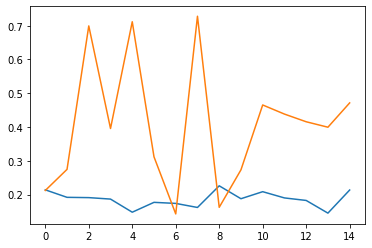

In [97]:
plt.plot(f_score_1_test_class)
plt.plot(f_score_1_test_emb)

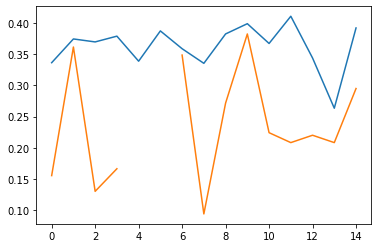

In [98]:
plt.plot(f_score_0_test_class)
plt.plot(f_score_0_test_emb)

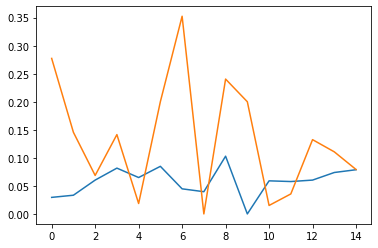

In [99]:
plt.plot(f_score_2_test_class)
plt.plot(f_score_2_test_emb)

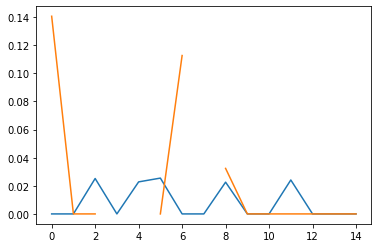

In [101]:
plt.plot(f_score_3_test_class)
plt.plot(f_score_3_test_emb)

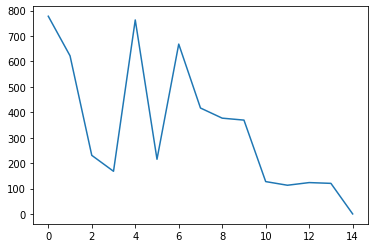

In [90]:
plt.plot([torch.nn.MSELoss()(ptsne(i.cuda()).cpu().detach(), projected_altered) for i in logits_emb['train']])